<table border="0" style="width:100%">
 <tr>
    <td>
        <img src="https://static-frm.ie.edu/university/wp-content/uploads/sites/6/2022/06/IE-University-logo.png" width=150>
     </td>
    <td><div style="font-family:'Courier New'">
            <div style="font-size:25px">
                <div style="text-align: right"> 
                    <b> MASTER IN BIG DATA</b>
                    <br>
                    Python for Data Analysis II
                    <br><br>
                    <em> Daniel Sierra Ramos </em>
                </div>
            </div>
        </div>
    </td>
 </tr>
</table>

# **S16: PyCaret - Automated Machine Learning in Python**

## 0. Data

You can download the data from the original source __[found here](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)__ and load it using the pandas read_csv function or you can use PyCaret's data respository to load the data using the get_data function (This will require an internet connection).

In [1]:
import pandas as pd

In [2]:
from pycaret.datasets import get_data
dataset = get_data('credit', profile=False)

Notice that when the `profile` parameter is to `True`, it displays a data profile for exploratory data analysis. Several pre-processing steps as discussed in section 2 above will be performed in this experiment based on this analysis. Let's summarize how the profile has helped make critical pre-processing choices with the data.

- **Missing Values:** There are no missing values in the data. However, we still need imputers in our pipeline just in case the new unseen data has missing values (not applicable in this case). When you execute the `setup()` function, imputers are created and stored in the pipeline automatically. By default, it uses a mean imputer for numeric values and a constant imputer for categorical. This can be changed using the `numeric_imputation` and `categorical_imputation` parameters in `setup()`. <br/>
<br/>
- **Multicollinearity:** There are high correlations between `BILL_AMT1 ... BIL_AMT6` which introduces multicollinearity into the data. We will remove multi-collinearity by using the `remove_multicollinearity` and `multicollinearity_threshold` parameters in setup. <br/>
<br/>
- **Data Scale / Range:** Notice how the scale / range of numeric features are different. For example the `AGE` feature ranges from between 21 to 79 and `BILL_AMT1` ranges from -165,580 to 964,511. This may cause problems for algorithms that assume all features have variance within the same order. In this case, the order of magnitude for `BILL_AMT1` is widely different than `AGE`. We will deal with this problem by using the `normalize` parameter in setup. <br/>
<br/>
- **Distribution of Feature Space:** Numeric features are not normally distributed. Look at the distributions of `LIMIT_BAL`, `BILL_AMT1` and `PAY_AMT1 ... PAY_AMT6`. A few features are also highly skewed such as `PAY_AMT1`. This may cause problems for algorithms that assume normal or approximate normal distributions of the data. Examples include Logistic Regression, Linear Discriminant Analysis (LDA) and Naive Bayes.  We will deal with this problem by using the `transformation` parameter in setup. <br/>
<br/>
- **Group Features:** From the data description we know that certain features are related with each other such as `BILL_AMT1 ... BILL_AMT6` and `PAY_AMT1 ... PAY_AMT6`. We will use the `group_features` parameter in setup to extract statistical information from these features.  <br/>
<br/>
- **Bin Numeric Features:** When looking at the correlations between the numeric features and the target variable, we that `AGE` and `LIMIT_BAL` are weak. We will use the `bin_numeric_features` parameter to remove the noise from these variables which may help linear algorithms. <br/>

In [3]:
#check the shape of data
dataset.shape

(24000, 24)

In order to demonstrate the `predict_model()` function on unseen data, a sample of 1200 rows has been withheld from the original dataset to be used for predictions. This should not be confused with a train/test split as this particular split is performed to simulate a real life scenario. Another way to think about this is that these 1200 records were not available at the time when the machine learning experiment was performed.

In [4]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (22800, 24)
Unseen Data For Predictions (1200, 24)


In [5]:
data["default"].sample(5)

4992     0
19731    0
12680    0
7342     0
2826     0
Name: default, dtype: int64

In [6]:
zeros = data[data.default==0].sample(frac=0.3)
data = data[data.default==1]
data = pd.concat([data,zeros])

## 1. Problem Definition

In [7]:
from pycaret.classification import (
    setup, 
    compare_models,
    create_model,
    tune_model,
    plot_model,
    finalize_model,
    save_model,
    load_model, 
    predict_model
)

In [25]:
model = setup(
    
    # Basic options
    data = data,
    target = "default",
    preprocess = False,
    train_size = 0.7,
    test_data = None,
        
    # Variable type definition
    categorical_features = None,
    numeric_features = None,
    date_features = None,
    ignore_features = None,
    
    # Dealing with missing values
    imputation_type = 'simple',
    iterative_imputation_iters = 5,
    categorical_imputation = 'constant',
    categorical_iterative_imputer = 'lightgbm',
    ordinal_features = None,
    #high_cardinality_features = None,
    #high_cardinality_method = 'frequency',
    numeric_imputation = 'mean',
    numeric_iterative_imputer = 'lightgbm',
    
    # Feature normalization
    normalize = False,
    normalize_method = 'zscore',
    
    # Apply transformations to variables
    transformation = False,
    transformation_method = 'yeo-johnson',
    #handle_unknown_categorical = True,
    #unknown_categorical_method = 'least_frequent',
    
    # Dimensioanlity reduction
    pca = False,
    pca_method = 'linear',
    pca_components = None,
    #ignore_low_variance = False,
    #combine_rare_levels = False,
    #rare_level_threshold = 0.1,
    bin_numeric_features = ['LIMIT_BAL', 'AGE'],
    
    # Outlier removal
    remove_outliers = False,
    outliers_threshold = 0.05,
    
    # Dealing with collinearity 
    remove_multicollinearity = False,
    multicollinearity_threshold = 0.9,
    #remove_perfect_collinearity = True,
    #create_clusters = False,
    #cluster_iter = 20,
    
    # Derived features generation
    polynomial_features = False,
    polynomial_degree = 2,
    #trigonometry_features = False,
    #polynomial_threshold = 0.1,
    group_features = None,
    group_names = None,
    
    # Feature selection
    feature_selection = False,
    #feature_selection_threshold = 0.8,
    feature_selection_method = 'classic',
    #feature_interaction = False,
    #feature_ratio = False,
    #interaction_threshold = 0.01,
    
    # Class unbalance
    fix_imbalance = False,
    fix_imbalance_method = None,
    
    # Cross-validation settings
    data_split_shuffle = True,
    data_split_stratify = False,
    fold_strategy = 'kfold',
    fold = 10,
    fold_shuffle = True,
    fold_groups = None,
    
    # Paralellization options
    n_jobs = - 1,
    use_gpu = False,
    
    # Here you can include your custom sklearn Pipeline
    custom_pipeline = None,
    
    # MLFlow experiments registry
    log_experiment = False,
    experiment_name = None,
    log_plots = False,
    log_profile = False,
    log_data = False,
    
    # Logging options
    #silent = False,
    verbose = True,
    
    # Do a profiling with Pandas Profiling
    profile = False,
    profile_kwargs = None,
    
    html = True,
    session_id = None
)

## 2. Compare models

```python
compare_models(
    include = None,
    exclude = None,
    fold = None,
    round = 4,
    cross_validation = True,
    sort = 'Accuracy',
    n_select = 1,
    budget_time = None,
    turbo = True,
    errors = 'ignore',
    fit_kwargs = None,
    groups = None,
    probability_threshold = None,
    verbose = True
)
```

In [26]:
models = compare_models(sort="AUC", fold=5)

# probability_threshold
# budget_time

In [27]:
models

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=1308, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## Create a model

```python
create_model(
    estimator = "gbc",
    fold = None,
    round = 4,
    cross_validation = True,
    fit_kwargs = None,
    groups = None,
    probability_threshold = None,
    verbose True
)
```

In [28]:
clf = create_model(models, fold=5)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:29:48
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7101,0.7715,0.6296,0.7330,0.6774,0.4168,0.4208
1,0.7197,0.7866,0.6424,0.7330,0.6847,0.4344,0.4374
2,0.6949,0.7619,0.6166,0.7015,0.6563,0.3841,0.3866
3,0.7167,0.7773,0.6375,0.7537,0.6907,0.4328,0.4380
4,0.7126,0.7761,0.6073,0.7774,0.6819,0.4269,0.4378
Mean,0.7108,0.7747,0.6267,0.7397,0.6782,0.4190,0.4241
Std,0.0086,0.0081,0.0130,0.0252,0.0118,0.0185,0.0199


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## 4. Optimize a model

```python
tune_model(
    estimator,
    fold = None,
    round = 4,
    n_iter = 10,
    custom_grid = None,
    optimize = 'Accuracy',
    custom_scorer = None,
    search_library 'scikit-learn',
    search_algorithm = None,
    early_stopping False,
    early_stopping_max_iters = 10,
    choose_better = False,
    fit_kwargs = None,
    groups = None,
    return_tuner = False,
    verbose = True,
    tuner_verbose = True
)
```

In [29]:
tuned_clf = tune_model(clf, optimize='AUC')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:29:55
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7094,0.7739,0.5594,0.7659,0.6466,0.4098,0.4244
1,0.7039,0.7805,0.4958,0.8349,0.6221,0.4036,0.4408
2,0.7039,0.7683,0.5234,0.7749,0.6248,0.3950,0.4158
3,0.7355,0.7871,0.5780,0.8130,0.6757,0.4630,0.4822
4,0.7218,0.7713,0.5616,0.7695,0.6493,0.4279,0.4425
5,0.6942,0.7623,0.5099,0.7860,0.6186,0.3821,0.4072
6,0.6956,0.7722,0.5352,0.7724,0.6323,0.3868,0.4058
7,0.6956,0.7837,0.5137,0.8139,0.6298,0.3930,0.4232
8,0.7090,0.7934,0.5043,0.8271,0.6265,0.4103,0.4441


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [39]:
print(tuned_clf.get_params())

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.0005, 'loss': 'log_loss', 'max_depth': 11, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 9, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 270, 'n_iter_no_change': None, 'random_state': 1308, 'subsample': 0.5, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


## Analyze the model

```python
plot_model(
    estimator,
    plot: str = 'auc',
    scale: float = 1,
    save: bool = False,
    fold: Optional[Union[int, Any]] = None,
    fit_kwargs: Optional[dict] = None,
    groups: Optional[Union[str, Any]] = None,
    use_train_data: bool = False,
    verbose: bool = True,
    display_format: Optional[str] = None
)
```

Opciones del parámetro `plot`:

`auc` - Area Under the Curve

`threshold` - Discrimination Threshold

`pr` - Precision Recall Curve

`confusion_matrix` - Confusion Matrix

`error` - Class Prediction Error

`class_report` - Classification Report

`boundary` - Decision Boundary

`rfe` - Recursive Feature Selection

`learning` - Learning Curve

`manifold` - Manifold Learning

`calibration` - Calibration Curve

`vc` - Validation Curve

`dimension` - Dimension Learning

`feature` - Feature Importance

`feature_all` - Feature Importance (All)

`parameter` - Model Hyperparameter

`lift` - Lift Curve

`gain` - Gain Chart

`tree` - Decision Tree

`ks` - KS Statistic Plot


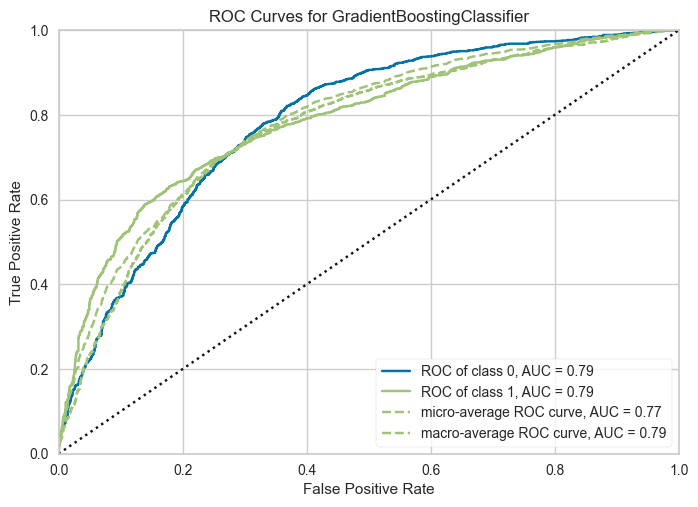

In [31]:
plot_model(tuned_clf, plot = 'auc')

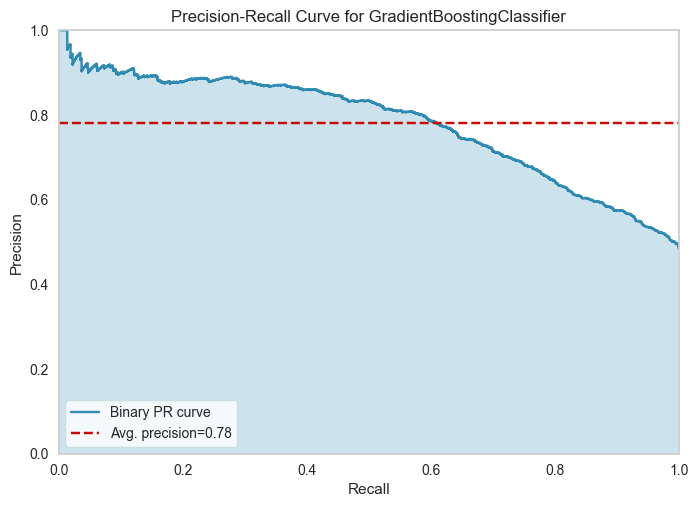

In [32]:
plot_model(tuned_clf, plot = 'pr')

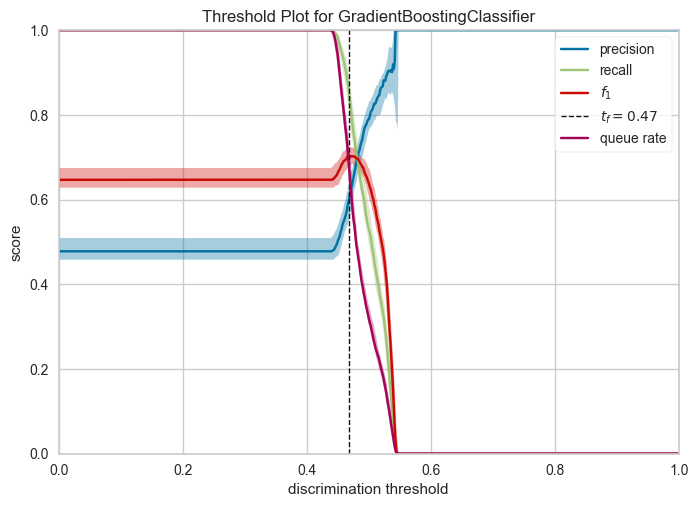

In [33]:
plot_model(tuned_clf, plot = 'threshold')

## 6. Save your model

In [34]:
# training model with all the data
model = finalize_model(tuned_clf)

In [35]:
# saving the whole PyCaret pipeline
pipeline = save_model(model, 'my_credit_model')

Transformation Pipeline and Model Successfully Saved


## 7. Use your model in production

In [36]:
# loading saved pipeline
pipeline = load_model(model_name="my_credit_model")

Transformation Pipeline and Model Successfully Loaded


In [37]:
# use model to predict
prediction = predict_model(pipeline, data_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8008,0.7903,0.5361,0.5465,0.5413,0.4141,0.4141


In [38]:
prediction

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,prediction_label,prediction_score
0,100000,2,2,2,23,0,-1,-1,0,0,...,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0,0,0.5182
1,380000,1,2,2,32,-1,-1,-1,-1,-1,...,11873.0,21540.0,15138.0,24677.0,11851.0,11875.0,8251.0,0,0,0.5619
2,200000,2,2,1,32,-1,-1,-1,-1,2,...,3151.0,5818.0,15.0,9102.0,17.0,3165.0,1395.0,0,0,0.5306
3,200000,1,1,1,53,2,2,2,2,2,...,149531.0,6300.0,5500.0,5500.0,5500.0,5000.0,5000.0,1,1,0.5419
4,240000,1,1,2,41,1,-1,-1,0,0,...,1737.0,2622.0,3301.0,0.0,360.0,1737.0,924.0,0,0,0.5049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,50000,1,2,1,37,1,2,2,2,0,...,1324.0,0.0,3000.0,0.0,0.0,1000.0,1000.0,1,1,0.5145
1196,220000,1,2,1,41,0,0,-1,-1,-2,...,1824.0,8840.0,6643.0,5924.0,1759.0,1824.0,7022.0,0,0,0.5449
1197,420000,1,1,2,34,0,0,0,0,0,...,147954.0,7000.0,7000.0,5500.0,5500.0,5600.0,5000.0,0,0,0.5523
1198,90000,1,2,1,36,0,0,0,0,0,...,14329.0,1500.0,1500.0,1500.0,1200.0,2500.0,0.0,1,0,0.5211
